In [14]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.transform import resize
from sklearn.metrics import precision_recall_curve, accuracy_score
from datetime import datetime
import matplotlib.pyplot as plt

Utility functions for loading and processing the audio and preparing the model

In [15]:
def load_sample(file_path, target_duration = 5, sr = 16000):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=sr)
    
    # Calculate the target length in samples
    target_length = int(target_duration * sr)
    
    # Trim or pad the audio
    if len(audio) > target_length:
        audio = audio[:target_length]  # Trim
    elif len(audio) < target_length:
        pad_length = target_length - len(audio)
        audio = np.pad(audio, (0, pad_length), mode='constant')  # Pad with zeros
    
    return audio, sr

def feature_extraction(audio, sr):
    mel_spectrogram = librosa.feature.melspectrogram(y = audio, sr = sr, n_mels=128) # Mel spectrogram
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max) # Convert to log scale
    
    # spectrogram = librosa.stft(y = audio)  # Short-Time Fourier Transform
    # spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)

    mfcc = librosa.feature.mfcc(S=mel_spectrogram_db, sr=sr, n_mfcc = 128)
    chroma = librosa.feature.chroma_stft(y = audio, sr = sr)
    
    return mel_spectrogram_db, mfcc, chroma

def preprocess_features(mel_spec, mfcc, chroma, target_size):
    # Resize the spectrogram to a consistent size
    #feature_stack = np.dstack((mel_spec, mfcc_resized, chroma_resized)) # Replace the line below with this line for 3D input and change the input shape of the model as well
    feature_stack = mel_spec
    return feature_stack

def build_model(input_shape):
    model = models.Sequential()

    # Input layer
    model.add(layers.InputLayer(input_shape=input_shape))

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    
    return model

Plotting tools

In [16]:
def plot_precision_recall_curve(y_true, y_scores, timestamp):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker=".")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.savefig(os.path.join(os.getcwd(), 'results', f'pr_curve_{timestamp}'))
    plt.show()

def plot_training_history(history, timestamp):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.savefig(os.path.join(os.getcwd(), 'results', f'training_history_{timestamp}'))

    plt.show()

Loading the audio files and extracting features

In [17]:
folder_path = os.getcwd()
# Data split roughly 80/10/10 (853 samples for training, 84 samples for validation and 104 samples for test)

X_train, Y_train = [], []
X_validate, Y_validate = [], []
X_test, Y_test = [], []

split_mapping = {
    "train": (X_train, Y_train),
    "validate": (X_validate, Y_validate),
    "test": (X_test, Y_test)
}

# Read data from folders inside the main folder
for split_name, (X_split, Y_split) in split_mapping.items():
    split_path = os.path.join(folder_path, 'dataset', split_name)
    
    # Process each .wav file in the split folder
    for file in os.listdir(split_path):
        if file.endswith('.wav'):
            file_path = os.path.join(split_path, file)
            label = 0 if file.startswith('car') else 1  # Encode labels (0: car, 1: tram)
            
            # Load audio and extract features
            audio, sr = load_sample(file_path)
            mel_spectrogram_db, mfcc, chroma = feature_extraction(audio, sr)

            # Plot the mel-scaled spectrogram
            # if file_path == os.path.join(folder_path, 'dataset', split_name, "car (1).wav") or file_path == os.path.join(folder_path, 'dataset', split_name, "tram (1).wav"):
            #     plt.figure(figsize=(10, 6))
            #     librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=512, x_axis="time", y_axis="mel", cmap="viridis")
            #     plt.colorbar(format="%+2.0f dB")
            #     plt.title(f"Mel Spectrogram from {split_name} file {file}")
            #     plt.xlabel("Time")
            #     plt.ylabel("Frequency")
            #     plt.show()

            features = mel_spectrogram_db
            # features = np.dstack((mel_spectrogram_db, mfcc, chroma))

            # Append features and label to the respective split
            X_split.append(features)
            Y_split.append(label)
            
    # Casting lists to np.darrays
    split_mapping[split_name] = (np.array(X_split), np.array(Y_split))

X_train, Y_train = split_mapping["train"]
X_validate, Y_validate = split_mapping["validate"]
X_test, Y_test = split_mapping["test"]


Model creation and fitting

In [18]:
# Debug
# print(X_test.shape, X_train.shape, X_validate.shape)
# print(Y_test.shape, Y_train.shape, Y_validate.shape)
input_shape = (X_train.shape[1], X_train.shape[2], 1)  # 1D image
model = build_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])   
history = model.fit(
    X_train, Y_train,
    validation_data=(X_validate, Y_validate),
    epochs=20
)

Epoch 1/20


/home/spaketti/.local/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5199 - loss: 7.3079 - val_accuracy: 0.5000 - val_loss: 0.6600
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.6694 - loss: 0.5966 - val_accuracy: 0.9762 - val_loss: 0.2351
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8964 - loss: 0.3045 - val_accuracy: 0.9762 - val_loss: 0.0869
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9586 - loss: 0.1248 - val_accuracy: 0.9881 - val_loss: 0.0593
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9575 - loss: 0.1312 - val_accuracy: 0.9881 - val_loss: 0.0505
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9571 - loss: 0.1116 - val_accuracy: 0.9643 - val_loss: 0.0786
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9754 - loss: 0.0738 - val_accuracy: 1.0000 - val_loss: 0.0274
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9717 - loss: 0.1022 - val_accuracy: 0.9881 - val_loss: 0.

Predictions and result plots

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test Accuracy: 1.00


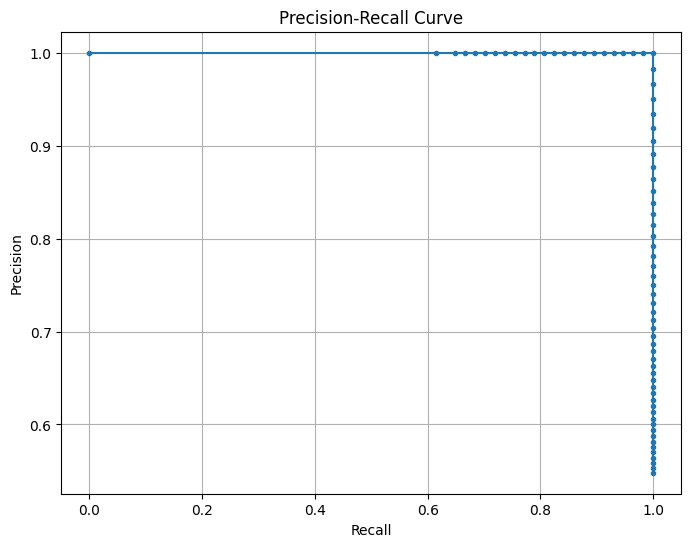

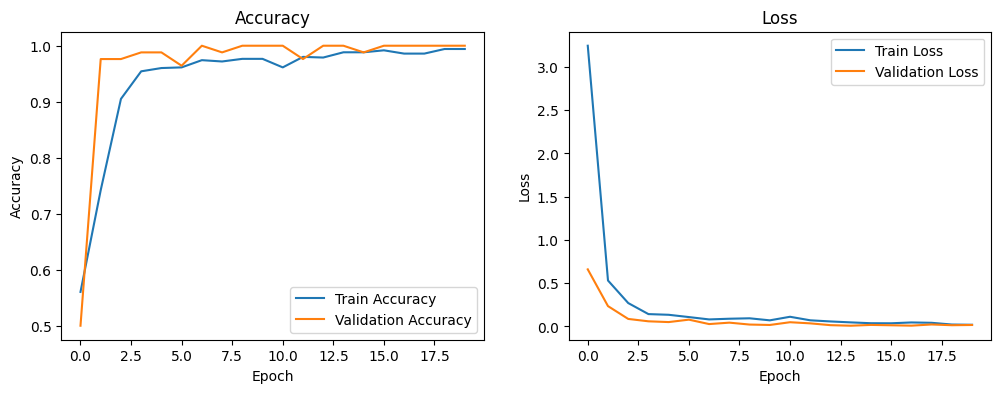

In [19]:
# Timestamp for file names
currTime = datetime.now()
timestamp = f'{currTime.year}_{currTime.month}_{currTime.day}_{currTime.hour}_{currTime.minute}__{currTime.second}'

Y_pred_prob = model.predict(X_test).ravel()
Y_pred = (Y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot Precision-Recall Curve
plot_precision_recall_curve(Y_test, Y_pred_prob, timestamp)

# Plot training history
plot_training_history(history, timestamp)